Mise en place

In [1]:
using Pkg
Pkg.activate("C:/Users/frank/Desktop/AOS212A/HW4/AOS212A_HW4") # Environment

  Activating project at `C:\Users\frank\Desktop\AOS212A\HW4\AOS212A_HW4`


In [2]:
# Packages
using Revise
using Profile
using ProgressMeter
using Plots
gr()
Plots.GRBackend()
using CurveFit, Printf
#using SparseArrays, LinearAlgebra, IterativeSolvers 


(process:21348): GLib-GIO-WARNING **: 22:13:59.273: Unexpectedly, UWP app `3138AweZip.AweZip_1.4.9.0_x86__ffd303wmbhcjt' (AUMId `3138AweZip.AweZip_ffd303wmbhcjt!App') supports 168 extensions but has no verbs


In [3]:
using HW4

## Problem Setup

Fully nonlinear, single-layer shallow water equation system in rotational form is given by

$$\begin{aligned}
\frac{\partial u}{\partial t}-q h v+\frac{\partial B}{\partial x} &=0 \\
\frac{\partial v}{\partial t}+q h u+\frac{\partial B}{\partial y} &=0 \\
\frac{\partial h}{\partial t}+\frac{\partial(h u)}{\partial x}+\frac{\partial(h v)}{\partial y} &=0,
\end{aligned}$$

where $h$ is the total water column height (can later be replaced by a bottom topography $h+z_b(x,y)$); $q=(\zeta+f) / h$ is the barotropic potential vorticity; $\zeta=(\partial v / \partial x-\partial u / \partial y)$ is the vertical vorticity; and $B=g h+\left(u^{2}+v^{2}\right) / 2$ is the total energy. This system conserves total mass, energy, and potential enstrophy (i.e. $(1/2)q^2$).

## Schemes

Spatial discretization: MAC grid (Arakawa C staggered grid)

Time discretization: Euler-Forward

## Test case

For a test case, we will study the geostrophic adjustment problem on the domain $0 \leq x \leq Lx$ and $0 \leq y \leq Ly$. For initial condition we will prescribe a quiescent state (with $u(t = 0) = v(t = 0) = 0$ everywhere) and a Gaussian unbalanced height given by

$$h(x, y, t=0)=H\left[1+\frac{1}{2} \exp \left(-\frac{\left(x-x_{0}\right)^{2}+\left(y-y_{0}\right)^{2}}{a^{2}}\right)\right],$$

where $a$ is the radius of the vortex at $(x_0,y_0)$.

### Parameters

In [95]:
g = 10^(-3) # m/s^2
H = 1000 # m
f = 10^(-4) # s^-1
c = sqrt(g*H)
λR = c/f
Lx = Ly = 10*λR
x0 = 5*λR
y0 = 5*λR
a = 1.25*λR;

In [96]:
Δx = Δy = 1000
Nx = (Lx-0)/Δx+1
Ny = (Ly-0)/Δy+1
x = 0:Δx:Lx
y = 0:Δy:Ly;

### Grid

In [97]:
# x components
#ux = Δx/2:Δx:(Lx+Δx/2)
ux = 0:Δx:Lx
#vx = 0:Δx:Lx
vx = Δx/2:Δx:(Lx+Δx/2)
#hx = 0:Δx:Lx
hx = Δx/2:Δx:(Lx+Δx/2)
#qx = Δx/2:Δx:(Lx+Δx/2)
qx = 0:Δx:Lx
# y components
#uy = 0:Δy:Ly
uy = Δy/2:Δy:(Ly+Δy/2)
#vy = Δy/2:Δy:(Ly+Δy/2)
vy = 0:Δy:Ly
#hy = 0:Δy:Ly
hy = Δy/2:Δy:(Ly+Δy/2)
#qy = Δy/2:Δy:(Ly+Δy/2)
qy = 0:Δy:Ly
# index
i = Int.(2:Nx-1)
j = Int.(2:Ny-1);

### Time

In [98]:
v_x = 42
Δt = 0.5*Δx/v_x # CFL condition
nsteps = 10000 # time steps
Co = 2*v_x*Δt/Δx # courant number

1.0

### Initial Condition

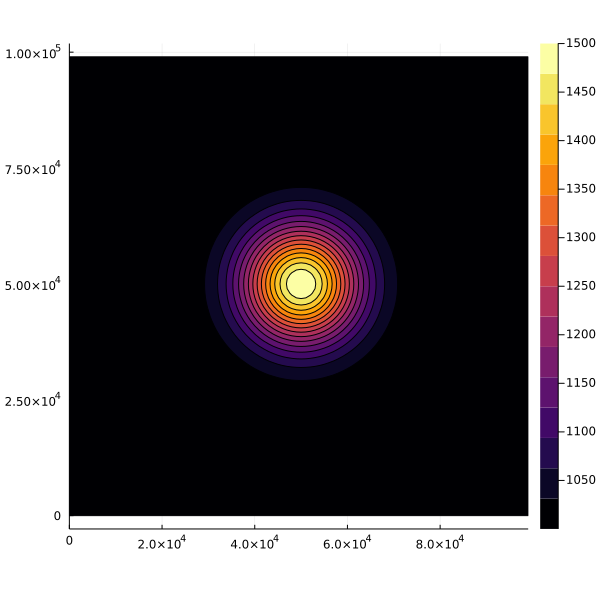

In [99]:
h0 = [H*(1+0.5*exp(-((x-x0)^2+(y-y0)^2)/a^2)) for x in 0:Δx:Lx, y in 0:Δy:Ly] 
contour(x,y,h0, fill = true, aspect_ratio=1.0, size=(600,600))

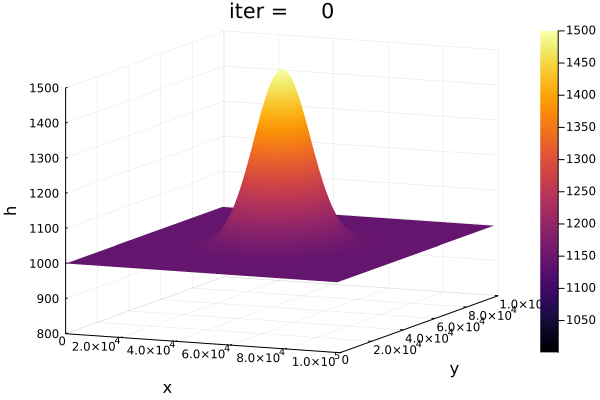

In [100]:
plot(x, y, h0, st = :surface, xlabel = "x", ylabel = "y", zlabel = "h", 
    xlim = (0, 10^5), ylim = (0, 10^5), zlim = (800,1500),
    title = @sprintf("iter = %5i",0))

In [101]:
u = zeros(length(ux),length(uy))
v = zeros(length(ux),length(uy))
h = h0;

### Boundary Condition

In [102]:
# BCtype = "no-slip"
 BCtype = "periodic"

"periodic"

In [103]:
ax1 = h.*ones(length(hx),length(hy))
q = f./h.*ones(length(qx),length(qy))
UU = zeros(length(ux),length(uy))
VV = zeros(length(ux),length(uy))
B = g.*h
axV = zeros(length(vx),length(vy)) 
ayU = zeros(length(ux),length(uy))
#ayax1 = zeros(length(qx),length(qy));

In [104]:
# operator functions
# δx(p)
dxfcn(p::AbstractMatrix) = (1/Δx).*(p[i.+1,j] .- p[i.-1,j])
# δy(p)
dyfcn(p::AbstractMatrix) = (1/Δy).*(p[i,j.+1] .- p[i,j.-1]) 
# ̅pˣ
axfcn(p::AbstractMatrix) = 0.5.*(p[i.+1,j] .+ p[i.-1,j]) 
# ̅pʸ
ayfcn(p::AbstractMatrix) = 0.5.*(p[i,j.+1] .+ p[i,j.-1]); 

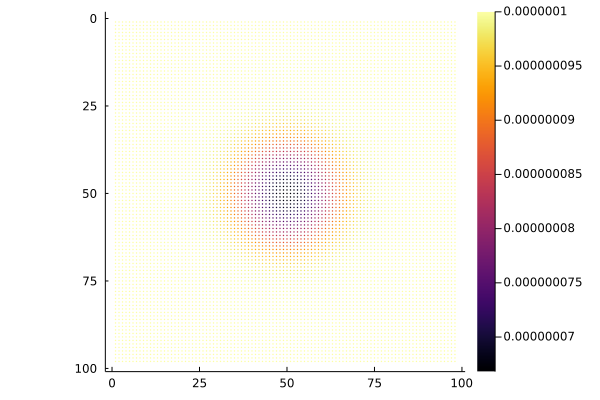

In [105]:
spy(ayfcn(q))

### Time Engine

In [106]:
# cache
ticache = []; Ecache = []; Zcache = []; hcache = []; qcache = []; ζcache = []; ucache = []; vcache = [];

# store
#nstore = 2
#nstore2 = 2
nstore = 50
nstore2 = 1000

# Euler forward
# March!
# anim = @animate
@showprogress 1 "Computing..."  for ti in 0:nsteps
    
    #update previous matrices
        u_n = deepcopy(u)
        v_n = deepcopy(v)
        h_n = deepcopy(h)
    
    # fields
        # UU = u*h; interpolate h to u positions
            UU[i,j] = axfcn(h) .* u[i,j]
            UU = HW4.applyBC(UU,BCtype)
        # VV = v*h; interpolate h to v positions
            VV[i,j] = ayfcn(h) .* v[i,j] 
            VV = HW4.applyBC(VV,BCtype)
        # B = gh + 1/2(u^2 + v^2); u and v are interpolated to h positions
            B[i,j] = g.*h[i,j] .+ 0.5.*(axfcn(u.^2) .+ ayfcn(v.^2))
            B = HW4.applyBC(B,BCtype)
        # q = (zeta + f)/h; u, v, and h are interpolated to q positions
            ax1[i,j] = axfcn(h)  # first interpolate h to u positions
            ax1 = HW4.applyBC(ax1,BCtype)
    
            q[i,j] = 1 ./ ayfcn(ax1) .* (dxfcn(v) .- dyfcn(u) .+ f) 
            ζ = dxfcn(v) .- dyfcn(u)
            q = HW4.applyBC(q,BCtype)

    # conserving enstrophy
        # u, to u positions
            axV[i,j] = axfcn(VV) # first interpolate V to q positions
            axV = HW4.applyBC(axV,BCtype)
            u[i,j] = u_n[i,j] .+ Δt.*(ayfcn(q) .* ayfcn(axV) .- dxfcn(B))
            u = HW4.applyBC(u,BCtype)
        # v, to v positions
            ayU[i,j] = ayfcn(UU) # first interpolate U to q positions
            ayU = HW4.applyBC(ayU,BCtype)
    
            v[i,j] = v_n[i,j] .+ Δt.*(- axfcn(q) .* axfcn(ayU) .- dyfcn(B))
            v = HW4.applyBC(v,BCtype)
        # h, to h positions
            h[i,j] = h_n[i,j] .+ Δt.*(- dxfcn(UU) .- dyfcn(VV))
            h = HW4.applyBC(h,BCtype)

    # conservation quantities
        # energy
        E = sum(B)
        # enstrophy
        Z = 0.5.*sum(q[i,j].^2 .* ayfcn(ax1)) 

    # store every 'nstore' time steps
    if mod(ti,nstore) == 0
        push!(ticache,deepcopy(ti)) # index
        push!(Ecache, deepcopy(E))  # energy
        push!(Zcache, deepcopy(Z))  # enstrophy
        push!(hcache, deepcopy(h))  # 
        push!(qcache, deepcopy(q))
        push!(ζcache, deepcopy(ζ))
        push!(ucache, deepcopy(u))
        push!(vcache, deepcopy(v))
    end  
    
     # plot
    #if mod(ti,nstore2) == 0
    #    display(plot(hx,hy,h, st = :surface, xlabel = "x", ylabel = "y", zlabel = "h", 
    #        title = @sprintf("iter = %5i",ti), xlim = (0, 10^5), ylim = (0, 10^5), zlim = (900,1500)))
        # xlim = (0, 10^5), ylim = (0, 10^5), zlim = (1000,1500)
             # axis([0 Lx 0 Ly 800 1500])
             #view(60,35)
             #cbar = colorbar;
             #caxis([900 1400])             
             #drawnow;
    #end
end

Computing...100%|███████████████████████████████████████| Time: 0:00:20


In [107]:
length(hcache)

201

In [108]:
anim = @animate for m in 1:length(hcache)
     plot(hx,hy,hcache[m], st = :surface, xlabel = "x", ylabel = "y", zlabel = "h", 
            title = @sprintf("iter = %5i",m*499), xlim = (0, 10^5), ylim = (0, 10^5), zlim = (750,1500))
end

Animation("C:\\Users\\frank\\AppData\\Local\\Temp\\jl_C1lFYL", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000192.png", "000193.png", "000194.png", "000195.png", "000196.png", "000197.png", "000198.png", "000199.png", "000200.png", "000201.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\frank\Desktop\AOS212A\HW4\AOS212A_HW4\notebook\tmp.gif
└ @ Plots C:\Users\frank\.julia\packages\Plots\9C6z9\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\frank\\Desktop\\AOS212A\\HW4\\AOS212A_HW4\\notebook\\tmp.gif")
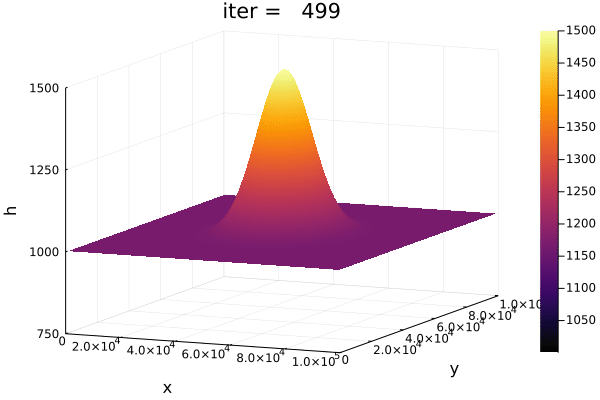

In [109]:
gif(anim, fps=8)

In [110]:
Ecache

201-element Vector{Any}:
 10245.436924476986
 10245.982311730284
 10247.526977537525
 10249.821337126501
 10252.527509570753
 10255.30180371761
 10257.86067684148
 10260.01703091124
 10261.687129558502
 10262.875743314069
 10263.649584397996
 10264.10838610415
 10264.360263648596
     ⋮
 10259.647352454966
 10259.953866327793
 10260.467492418562
 10260.919692216992
 10261.101147327568
 10260.892240694615
 10260.24577388221
 10259.166647991007
 10257.711613624357
 10255.996643921055
 10254.187017717453
 10252.46470321451

In [111]:
Zcache

201-element Vector{Any}:
 4.702258928909453e-8
 4.702258930062544e-8
 4.702258943370844e-8
 4.7022589773005816e-8
 4.702259037170913e-8
 4.702259123681036e-8
 4.7022592332304484e-8
 4.702259359006097e-8
 4.7022594924754434e-8
 4.702259624923288e-8
 4.702259748738455e-8
 4.70225985826627e-8
 4.702259950169206e-8
 ⋮
 4.702261586621392e-8
 4.702261614704332e-8
 4.702261643729422e-8
 4.702261671752995e-8
 4.702261696845277e-8
 4.702261717549939e-8
 4.7022617331987824e-8
 4.702261743937301e-8
 4.702261750496314e-8
 4.7022617539208956e-8
 4.7022617554449606e-8
 4.7022617565024356e-8

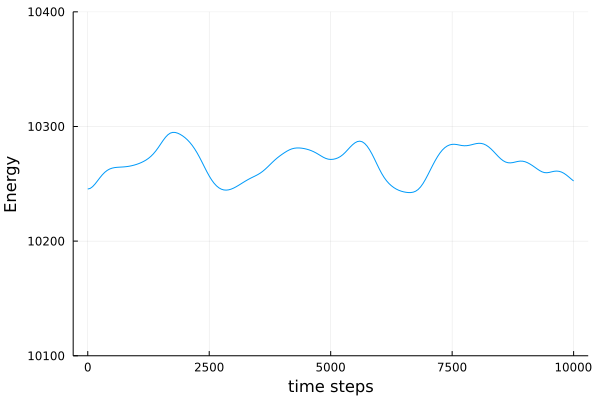

In [118]:
plot(ticache,Ecache,ylim = (10100, 10400),xlabel = "time steps", ylabel = "Energy",lab="")

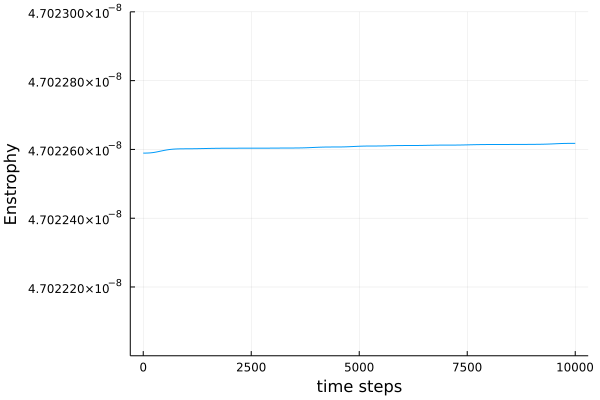

In [123]:
plot(ticache,Zcache, ylim = (4.7022*10^-8, 4.7023*10^-8), xlabel = "time steps", ylabel = "Enstrophy",lab="")